The DBLEU Loss follows this paper : https://openreview.net/forum?id=S1x2aiRqFX 

#Import library

In [61]:
!nvidia-smi

Sat May 21 14:45:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |   9857MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import sys
sys.path.append('/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/00 Library/')
!pip install --upgrade pythainlp
!pip install torchinfo
!pip install torchviz

In [64]:
from data_processing_non import dictionary
from model_dataloader import EncoderDecoder

In [65]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random


import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms, models
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary

from sklearn.model_selection import train_test_split

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Data set and Data loader


In [67]:
def get_identical_matrix(vector):
  identical_matrix = torch.eye(len(vector))

  for i in range(len(vector)):
    for j in range(len(vector)):
      identical_matrix[i, j] = vector[i] == vector[j]

  return identical_matrix

def get_n_gram_hadamard_operation(matrix, n = 4):
  outputs = []
  matrix_n = matrix
  outputs.append(matrix)

  w = matrix.shape[0]
  h = matrix.shape[1]

  for i in range(1, n):
    if w-i <= 0 or h-i <= 0:
      break
    matrix_n = matrix[:-i, :-i] * matrix_n[1:, 1:]
    outputs.append(matrix_n)

  return outputs 

def get_similarity_matrix(pred, caption):
  T = len(caption)
  output = torch.zeros(T, T)
  for i in range(T):
    for j in range(T):
      output[i, j] = pred[i, caption[j]].contiguous()
  return output

In [68]:
class FlickrDataset_Bleu_loss(Dataset):
    def __init__(self, 
                 captions_files, 
                 image_dir = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/00 Data/archive/Images/", 
                 transform=None,
                 dictionary=dictionary,
                 test = False):
      
      self.image_dir = image_dir

      if type(captions_files) is str:
        self.dfs = pd.read_csv(captions_files)
        self.dfs = [self.df]
      elif type(captions_files) is list:
        for i in range(len(captions_files)):
          if  type(captions_files[i]) is str:
            captions_files[i] = pd.read_csv(captions_files[i])
        self.dfs = captions_files

      self.transform = transform
      self.test = test
      self.img_id = []
      self.img = {}
      self.caption = {}
      self.dictionary = dictionary

      self.caption_n_gram_count = {}

      unique_image = self.dfs[0]['image'].unique()

      for i in tqdm(range(len(unique_image))):
        img_id = unique_image[i]
        if img_id in self.caption:
          continue
        self.img_id.append(img_id)
        self.caption[img_id] = []
        self.caption_n_gram_count[img_id] = []
      
      for df in self.dfs:

        for i in tqdm(range(len(df))):
          img_id = df.iloc[i]['image']
          caption = df.iloc[i]['tokenized_caption_th']

          caption = caption[1:-1]
          caption = caption.split(",")
          caption = [word[1:].replace("'", "") for word in caption] 
          caption = self.dictionary.numericalize(caption)
          caption = torch.tensor(caption)
          
          identical_matrix = get_identical_matrix(caption[1:-1])
          n_gram_indentical_matrices = get_n_gram_hadamard_operation(identical_matrix)
          n_gram_count = [torch.sum(matrix, dim = 1) for matrix in n_gram_indentical_matrices]
          self.caption[img_id].append(caption)
          self.caption_n_gram_count[img_id].append(n_gram_count)
        
        
    def __len__(self):
      return len(self.img_id)
    
    def __getitem__(self, idx): 

      img_id = self.img_id[idx]
      if img_id not in self.img:
        img_path = os.path.join(self.image_dir, img_id)
        img = Image.open(img_path).convert("RGB")
        self.img[img_id] = img

      img = self.img[img_id]
      randomized_index = random.randint(0, len(self.caption[img_id])-1)
      caption = self.caption[img_id][randomized_index]
      caption_n_gram_count = self.caption_n_gram_count[img_id][randomized_index]

      if self.transform is not None:
        transformed_img = self.transform(img)

      if not self.test:
        return transformed_img, caption, caption_n_gram_count, img

      return transformed_img, caption, caption_n_gram_count, img, self.caption[img_id]
      

In [69]:
# Collate_fn for calling to transform a batch before return. 
class Collate_fn:
  def __init__(self, pad_value, batch_first=False):
    self.pad_value = pad_value       
    self.batch_first = batch_first    
        
  def __call__(self, batch):
    transformed_imgs = [item[0].unsqueeze(0) for item in batch]
    transformed_imgs = torch.cat(transformed_imgs, dim=0)    
        
    captions = [item[1] for item in batch]   
    captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)
    
    if len(batch[0]) > 4:
      return transformed_imgs, captions, [item[2] for item in batch], [item[3] for item in batch], [item[4] for item in batch]

    return transformed_imgs, captions, [item[2] for item in batch], [item[3] for item in batch]

In [70]:
dataframe_path = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/00 Data/archive/"

In [71]:
train_captions_files = [dataframe_path+"captions_train.csv"]
val_captions_files = [dataframe_path+"captions_val.csv"]
test_captions_files = [dataframe_path+"captions_test.csv"]

image_size = 299

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

In [72]:
batch_size = 32
train_flickr_bleu_dataset = FlickrDataset_Bleu_loss(transform = train_transform, captions_files = train_captions_files)
train_flickr_bleu_dataloader = torch.utils.data.DataLoader( train_flickr_bleu_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 
val_flickr_bleu_dataset = FlickrDataset_Bleu_loss(transform = val_transform, captions_files = val_captions_files)
val_flickr_bleu_dataloader = torch.utils.data.DataLoader( val_flickr_bleu_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 
test_flickr_bleu_dataset = FlickrDataset_Bleu_loss(transform = val_transform, captions_files = test_captions_files, test = True)
test_flickr_bleu_dataloader = torch.utils.data.DataLoader( test_flickr_bleu_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 

  0%|          | 0/5663 [00:00<?, ?it/s]

  0%|          | 0/28315 [00:00<?, ?it/s]

  0%|          | 0/1214 [00:00<?, ?it/s]

  0%|          | 0/6070 [00:00<?, ?it/s]

  0%|          | 0/1214 [00:00<?, ?it/s]

  0%|          | 0/6070 [00:00<?, ?it/s]

In [73]:
len(next(iter(test_flickr_bleu_dataloader)))

5

#BLEU Loss Function

In [74]:
from torch.autograd import Variable
eps = 1e-8
class BLEU_loss(nn.Module):
  def __init__(self, N_max = 4):
    super().__init__()
    self.N_max = N_max 
    self.weight = torch.tensor([0.1, 0.3, 0.3, 0.3])
        
  def forward(self, preds, captions, Cs):
    prec = torch.zeros(len(preds))
    BP = torch.zeros(len(preds))

    for index in range(len(preds)):
      caption = captions[index]

      stop_word_index = (caption == 2).nonzero()[0]
      caption = caption[1:stop_word_index]
      T = len(caption)

      pred = preds[index]
      text_output = torch.argmax(pred, dim = 1)
      if 2 in text_output:
        stop_word_index_pred = (text_output == 2).nonzero()[0]
        text_output = text_output[:stop_word_index_pred]
      else :
        text_output = text_output
      pred = pred[:stop_word_index]
      pred = nn.functional.softmax(pred, dim=1)

      similarity_matrix = get_similarity_matrix(pred, caption)
      Ms = get_n_gram_hadamard_operation(similarity_matrix) 

      C = Cs[index]
      Os = torch.tensor([0.0 for _ in range(self.N_max)])

      for n in range(self.N_max):
        if n >= len(Ms):
          break
        M = Ms[n]
        diag = torch.diagonal(M, 0)
        temp = 1 + torch.sum(M, dim = 1) - diag 

        appearance_number = C[n]
        min_part = appearance_number/temp
        min_part = torch.clamp(min_part, max = 1)

        #print(M.shape, appearance_number.shape, min_part.shape)
        temp = (M.T/appearance_number*min_part).T
        temp = torch.sum(temp)
        Os[n] = torch.log(temp/(T-n)+eps)

      number_word_real = len(caption)
      number_word_pred = len(text_output)
      if number_word_real > number_word_pred:
        BP[index] = -torch.log(torch.exp(torch.tensor(1-number_word_real/(number_word_pred+eps))))
      prec[index] = -torch.sum(Os*self.weight)
      

    BP = torch.mean(BP) 
    prec = torch.mean(prec) 

    return BP+prec

#Config

In [75]:
#Config

embed_size=300
vocab_size = len(dictionary.stoi)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 1e-3
number_of_decode_layer = 1

model_name = "model_4"
base_path = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/01 Model/Anon/"
crossentropy_path = base_path + "baseline_"+model_name+"_state.pth"
mixed_path = base_path + model_name+"_state.pth"

#Model

In [76]:
transformed_img, captions, caption_n_gram_count, img = next(iter(train_flickr_bleu_dataloader))
transformed_img, captions = transformed_img.to(device), captions.to(device)

In [77]:
model = EncoderDecoder(embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim, number_of_decode_layer).to(device)

In [78]:
#best_path = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/01 Model/Anon/baseline_attention_cross_ling_model_state.pth"
#best = torch.load(best_path)
#model.load_state_dict(best['state_dict'])

#Training


In [79]:
bleu_loss_fn = BLEU_loss()
criterion = nn.CrossEntropyLoss(ignore_index=dictionary.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 0, min_lr = 1e-7)

In [80]:
def save_model(model,num_iteration, crossentropy):
    best_path = crossentropy_path if crossentropy == True else mixed_path
    model_state = {
        'num_epochs':num_iteration,
        'embed_size':embed_size,
        'vocab_size':vocab_size,
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }
    torch.save(model_state, best_path)
    print(best_path)

In [81]:
import math
num_epoch = 25
best_val = float('inf')
lrs = []

train_losses = []
val_losses = []

train_bleu_losses = []
train_cross_entropy_losses = []

val_bleu_losses = []
val_cross_entropy_losses = []



for i in tqdm(range(num_epoch)): 

  model.train()
  
  total_train_loss = 0 
  total_train_bleu_loss = 0
  total_train_cross_entropy_loss = 0
  count = 0 

  for transformed_img, captions, caption_n_gram_count, _ in tqdm(train_flickr_bleu_dataloader):
  
    optimizer.zero_grad()
    transformed_img, captions = transformed_img.to(device), captions.to(device)

    outputs, attentions = model(transformed_img, captions)
    bleu_loss = bleu_loss_fn(outputs, captions, caption_n_gram_count)
    criterion_loss = criterion(outputs.reshape(-1, vocab_size), captions[:,1:].reshape(-1))

    train_loss = criterion_loss
    train_loss.backward()

    total_train_bleu_loss += bleu_loss
    total_train_cross_entropy_loss += criterion_loss
    total_train_loss += train_loss
    count+= 1
    optimizer.step()

  total_train_loss /= count
  total_train_bleu_loss /= count
  total_train_cross_entropy_loss /= count
  scheduler.step(total_train_loss)
  lrs.append(optimizer.param_groups[0]['lr'])

  train_losses.append(train_loss.item())
  train_bleu_losses.append(total_train_bleu_loss.item())
  train_cross_entropy_losses.append(total_train_cross_entropy_loss.item())

  model.eval()
  total_val_loss = 0 
  total_val_bleu_loss = 0
  total_val_cross_entropy_loss = 0
  count = 0 
  with torch.no_grad():
    for transformed_img, captions, caption_n_gram_count, _ in val_flickr_bleu_dataloader:
      transformed_img, captions = transformed_img.to(device), captions.to(device)
      outputs, attentions = model(transformed_img, captions)
      bleu_loss = bleu_loss_fn(outputs, captions, caption_n_gram_count)
      criterion_loss = criterion(outputs.reshape(-1, vocab_size), captions[:,1:].reshape(-1))

      val_loss = criterion_loss

      total_val_loss += val_loss
      total_val_bleu_loss += bleu_loss
      total_val_cross_entropy_loss += criterion_loss
      count += 1

    total_val_loss /= count
    total_val_bleu_loss /= count
    total_val_cross_entropy_loss/= count

    val_losses.append(total_val_loss.item())
    val_bleu_losses.append(total_val_bleu_loss.item())
    val_cross_entropy_losses.append(total_val_cross_entropy_loss.item())
    
    if bleu_loss < best_val:
      best_val = bleu_loss
      save_model(model, i, True)

    transformed_img, captions, _, img = next(iter(val_flickr_bleu_dataloader)) 
    transformed_img, captions = transformed_img.to(device), captions.to(device)
    text_output, _ = model.generate_text(transformed_img)

    print("LR : ", lrs[-1],"Train loss : ", total_train_loss, "Val loss : ",total_val_loss, "BLEU loss : ",bleu_loss)
    print("Total_train_loss : ", total_train_loss)
    print("Total_train_bleu_loss : ", total_train_bleu_loss)
    print("Total_train_cross_entropy_loss : ", total_train_cross_entropy_loss)
    print("Total_val_loss : ", total_val_loss)
    print("Total_val_bleu_loss : ", total_val_bleu_loss)
    print("Total_val_cross_entropy_loss : ", total_val_cross_entropy_loss)
    print()
    for i in range(5):
      print("Real: ", "".join([ dictionary.itos[i] for i in captions[i].cpu().detach().numpy() ]))
      print("Prodicted: ", "".join(text_output[i]))
      plt.imshow(img[i])
      plt.show()
    print()

  

Output hidden; open in https://colab.research.google.com to view.

In [82]:
import math

best_val = float('inf')
num_epoch = 5
learning_rate = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 0, min_lr = 1e-8)

best = torch.load(crossentropy_path)
model.load_state_dict(best['state_dict'])

for i in tqdm(range(num_epoch)): 

  model.train()
  total_train_loss = 0 
  total_train_bleu_loss = 0
  total_train_cross_entropy_loss = 0
  count = 0 

  for transformed_img, captions, caption_n_gram_count, _ in tqdm(train_flickr_bleu_dataloader):
  
    optimizer.zero_grad()
    transformed_img, captions = transformed_img.to(device), captions.to(device)

    outputs, attentions = model(transformed_img, captions)
    bleu_loss = bleu_loss_fn(outputs, captions, caption_n_gram_count)
    criterion_loss = criterion(outputs.reshape(-1, vocab_size), captions[:,1:].reshape(-1))

    train_loss = bleu_loss
    train_loss.backward()

    total_train_loss += train_loss
    total_train_bleu_loss += bleu_loss
    total_train_cross_entropy_loss += criterion_loss
    count += 1
    optimizer.step()

  total_train_loss /= count
  total_train_bleu_loss /= count
  total_train_cross_entropy_loss /= count
  
  train_losses.append(train_loss.item())
  train_bleu_losses.append(total_train_bleu_loss.item())
  train_cross_entropy_losses.append(total_train_cross_entropy_loss.item())
  
  scheduler.step(total_train_loss)
  lrs.append(optimizer.param_groups[0]['lr'])

  model.eval()
  total_val_loss = 0 
  total_val_bleu_loss = 0
  total_val_cross_entropy_loss = 0
  count = 0 
  with torch.no_grad():
    for transformed_img, captions, caption_n_gram_count, _ in val_flickr_bleu_dataloader:
      transformed_img, captions = transformed_img.to(device), captions.to(device)
      outputs, attentions = model(transformed_img, captions)
      bleu_loss = bleu_loss_fn(outputs, captions, caption_n_gram_count)
      criterion_loss = criterion(outputs.reshape(-1, vocab_size), captions[:,1:].reshape(-1))

      val_loss = bleu_loss

      total_val_loss += val_loss
      total_val_bleu_loss += bleu_loss
      total_val_cross_entropy_loss += criterion_loss
      count += 1

    total_val_loss /= count
    total_val_bleu_loss /= count
    total_val_cross_entropy_loss/= count

    val_losses.append(total_val_loss.item())
    val_bleu_losses.append(total_val_bleu_loss.item())
    val_cross_entropy_losses.append(total_val_cross_entropy_loss.item())

    if bleu_loss < best_val:
      best_val = bleu_loss
      save_model(model, i, False)

    transformed_img, captions, _, img = next(iter(val_flickr_bleu_dataloader)) 
    transformed_img, captions = transformed_img.to(device), captions.to(device)
    text_output, _ = model.generate_text(transformed_img)

    print("LR : ", lrs[-1],"Train loss : ", total_train_loss, "Val loss : ",total_val_loss, "BLEU loss : ",bleu_loss)
    print("Total_train_loss : ", total_train_loss)
    print("Total_train_bleu_loss : ", total_train_bleu_loss)
    print("Total_train_cross_entropy_loss : ", total_train_cross_entropy_loss)
    print("Total_val_loss : ", total_val_loss)
    print("Total_val_bleu_loss : ", total_val_bleu_loss)
    print("Total_val_cross_entropy_loss : ", total_val_cross_entropy_loss)
    for i in range(5):
      print("Real: ", "".join([ dictionary.itos[i] for i in captions[i].cpu().detach().numpy() ]))
      print("Prodicted: ", "".join(text_output[i]))
      plt.imshow(img[i])
      plt.show()
    print()

  

Output hidden; open in https://colab.research.google.com to view.

#BLEU eval

In [83]:
def show_image_for_testing(all_captions, text_output, img):
  print()
  print("Predicted: ", "".join(text_output))
  for caption in all_captions:
    caption = [dictionary.itos[token.item()] for token in caption]
    reference.append(caption)
    print("Real: ", "".join(caption))
  print(sentence_bleu(reference, text_output))
  plt.imshow(img)
  plt.show()

  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



Predicted:  <start>ชายคนหนึ่งยืนอยู่หน้าประตูทางเข้าประตู<end>
Real:  <start>ผู้หญิงที่แผงขายอาหารกลางแจ้ง .<end>
Real:  <start>ผู้หญิงซื้อสินค้าจากพ่อค้าแม่ค้ากลางแจ้ง<end>
Real:  <start>ผู้หญิงในเสื้อแจ็กเก็ตสีแดงดูราวกับว่าเธอกำลังซื้อบางอย่างจากผู้ขายกลางแจ้ง<end>
Real:  <start>ผู้หญิงกำลังซื้อสินค้า<end>
Real:  <start>ผู้หญิงในชุดแดงซื้อของจากพ่อค้าแม่ค้าข้างถนน<end>
0.6529942057256104


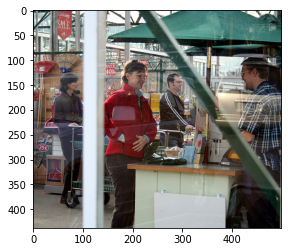


Predicted:  <start>ผู้หญิงสองคนสวมชุดฮาวายและกระโปรงสีขาวและกระโปรงสีขาว และหมวกสีขาว 
Real:  <start>ผู้หญิงสองคนสวมกระโปรงเดินไปตามถนนด้วยกัน<end>
Real:  <start>ผู้หญิงสองคนในชุดกระโปรงเดินข้ามถนน<end>
Real:  <start>ผู้หญิงสองคนในชุดกระโปรงเดินผ่านลานจอดรถ<end>
Real:  <start>ผู้หญิงสองคนสวมกระโปรงและถือกระเป๋าข้ามถนนในเขตเมือง<end>
Real:  <start>ผู้หญิงสองคนถือกระเป๋าเดินอยู่ในเมือง<end>
0.19120817575042506


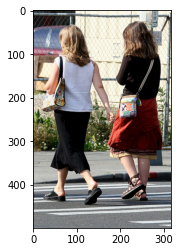


Predicted:  <start>ชายคนหนึ่งกำลังเล่นเบสบอล<end>
Real:  <start>เด็กในเสื้อเชิ้ตสีขาวปรบมือ<end>
Real:  <start>เด็กสาวยกมือขึ้นท่ามกลางผู้คนมากมาย<end>
Real:  <start>เด็กชายตัวเล็ก ๆ สวมเสื้อเชิ้ตสีขาวและกางเกงสีเทาดูเหมือนจะเต้นอยู่<end>
Real:  <start>เด็กหนุ่มเต้นรำท่ามกลางฝูงชน<end>
Real:  <start>ฝูงชนข้างนอกมีเด็กอยู่ตรงกลางโดยยกมือขึ้น<end>
0.7071067811865476


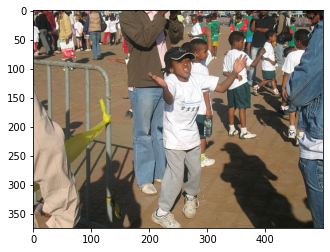


Predicted:  <start>ชายคนหนึ่งถือตะกร้าไว้บนผ้าห่ม<end>
Real:  <start>สุนัขมีหัวอยู่ในถุงของขวัญสีแดงและสีเขียว<end>
Real:  <start>สัตว์เลี้ยงสำรวจสิ่งของในถุงของขวัญอย่างสนุกสนาน<end>
Real:  <start>หมาน้อยสีน้ำตาลทิ่มหัวอยู่ในถุงผ้าหลากสีสัน<end>
Real:  <start>สุนัขมีใบหน้าของเขาในถุงของขวัญคริสต์มาส<end>
Real:  <start>สุนัขสีน้ำตาลแดงขุดจมูกเพื่อตรวจสอบถุงของขวัญวันหยุด<end>
0.668740304976422


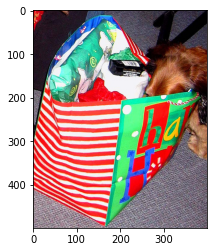


Predicted:  <start>สุนัขสีดำวิ่งอยู่บนพื้นหญ้า<end>
Real:  <start>สุนัขสีดำกำลังวิ่งข้ามหญ้าโดยถืออะไรบางอย่างเข้าปาก<end>
Real:  <start>สุนัขสีดำกำลังวิ่งออกไปข้างนอกโดยมีของเล่นอยู่ในปาก<end>
Real:  <start>สุนัขสีดำวิ่งไปตามหญ้าสีเขียวโดยถือของเล่นเข้าปาก<end>
Real:  <start>สุนัขสีดำวิ่งบนหญ้าสีเขียวพร้อมของเล่นในปากของเขา<end>
Real:  <start>หมาดำกำลังถืออะไรบางอย่างเข้าปากและวิ่งไปในหญ้า<end>
0.3218548743654149


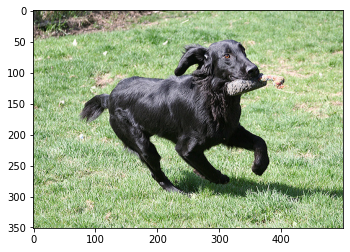


Predicted:  <start>กลุ่มคนที่มีผ้าโพกศีรษะสีดำและสีขาวและสีขาวและสีดำและสีขาว
Real:  <start>ผู้คนจำนวนมากกำลังดูนักเล่นสโนว์บอร์ดเล่นกล<end>
Real:  <start>ฝูงชนกำลังดูนักสเก็ตบอร์ด<end>
Real:  <start>นักเล่นสเก็ตบอร์ดเล่นกลต่อหน้าฝูงชนจำนวนมาก<end>
Real:  <start>ผู้ชมดูเป็นนักเล่นสโนว์บอร์ดเล่นกล<end>
Real:  <start>เด็กกำลังอวดสเก็ตบอร์ดต่อหน้าฝูงชนจำนวนมาก<end>
0.4671379777282001


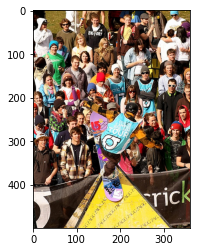


Predicted:  <start>เด็กสองคนยิ้มและยิ้ม<end>
Real:  <start>หญิงสาวเป่าฟองสบู่ลงไปในน้ำ<end>
Real:  <start>หญิงสาวที่มีศีรษะยื่นออกมาจากน้ำที่ปากของเธอ<end>
Real:  <start>หญิงสาวที่มีตาสีน้ำตาลนั่งอยู่ในน้ำ<end>
Real:  <start>หญิงสาวกำลังว่ายน้ำโดยมีเพียงหัวของเธออยู่เหนือน้ำ<end>
Real:  <start>หญิงสาวที่มีผมสีน้ำตาลว่ายอยู่ในน้ำ<end>
0.7071067811865476


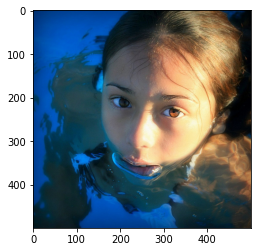


Predicted:  <start>กลุ่มเด็กเล่นในชุดขาว<end>
Real:  <start>ผู้หญิงผมบลอนด์และผมแดงนั่งดื่มด้วยกัน<end>
Real:  <start>ผู้หญิงสองคนกำลังนั่งดื่มเครื่องดื่มบรรจุขวด<end>
Real:  <start>ผู้หญิงสองคนดื่มจากขวดสีเขียว<end>
Real:  <start>ผู้หญิงสองคนดื่มจากขวดสีเขียวขณะนั่ง<end>
Real:  <start>ผู้หญิงสองคนดื่มขณะนั่งอยู่ใต้แท่น<end>
0.7071067811865476


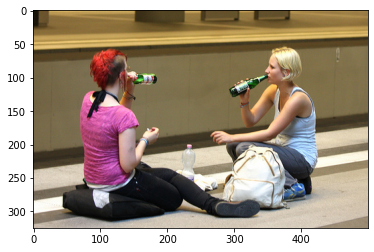


Predicted:  <start>เหยือกเบสบอล .<end>
Real:  <start>ผู้คนในชุดขาวยืนอยู่บนสนามกีฬาในขณะที่ฝูงชนมองจากอัฒจันทร์<end>
Real:  <start>ผู้เล่นสามคนในเครื่องแบบเหยียดบนพื้นสีเขียวลายต่อหน้าฝูงชนจำนวนมากและป้าย<end>
Real:  <start>ผู้เล่นเบสบอลสามคนอยู่บนสนามในขณะที่ฝูงชนจำนวนมากกำลังดูอยู่<end>
Real:  <start>ชายสามคนยืนอยู่บนสนามกีฬาต่อหน้าฝูงชนจำนวนมาก<end>
Real:  <start>ชายสามคนสวมเครื่องแบบสีขาวยืนอยู่บนสนามหญ้าต่อหน้าฝูงชน<end>
0.43173061492439624


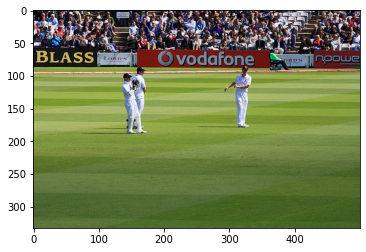


Predicted:  <start>เด็กสองคนกำลังเล่นกับสุนัขตัวเล็ก ๆ ในสวนสาธารณะ<end>
Real:  <start>หญิงสาวในหมวกคาวบอยพร้อมสายจูงแกะ<end>
Real:  <start>หญิงสาวสวมหมวกสีชมพูกำลังเดินอยู่ข้างแกะบนเส้นทางที่เต็มไปด้วยฝุ่น<end>
Real:  <start>เด็กหญิงตัวเล็ก ๆ สวมหมวกคาวเกิร์ลสีชมพูและสวมแขนสีน้ำเงิน กำลังเดินแกะอยู่<end>
Real:  <start>เด็กสาวสวมหมวกคาวบอยสีชมพูถือแกะด้วยสายจูง<end>
Real:  <start>หญิงสาวสวมหมวกคาวเกิร์ลสีชมพูและรองเท้าบูทสีชมพู<end>
0.195647514979229


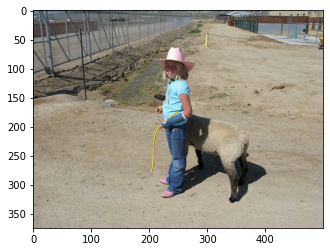


Predicted:  <start>สุนัขสีดำและสีขาวกำลังกระโดดขึ้นไปในอากาศเพื่อจับจานร่อน<end>
Real:  <start>สุนัขขาวดำกระโดดขึ้นไปในอากาศ<end>
Real:  <start>สุนัขขาวดำกระโดดไปจับลูกบอล<end>
Real:  <start>สุนัขกระโดดสูงในอากาศในประเทศ<end>
Real:  <start>สุนัขกระโดดร่มเงาของต้นไม้<end>
Real:  <start>สุนัขกระโดดสูงโดยอ้าปากค้าง<end>
0.1934529902282619


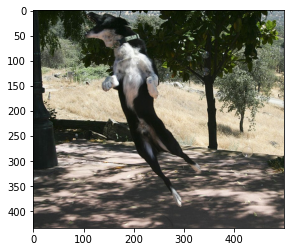

In [84]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
avg_bleu_score = 0
count = 0
max_count = 10
model.eval()

ref = list()
predict = list()

best = torch.load(mixed_path)
model.load_state_dict(best['state_dict'])


with torch.no_grad():
  for transformed_img, captions, caption_n_gram_count, img, all_captions in tqdm(test_flickr_bleu_dataloader):
    transformed_img, captions = transformed_img.to(device), captions.to(device)
    text_output, _ = model.generate_text(transformed_img)
    for i in range(len(all_captions)):
      reference = []
      for caption in all_captions[i]:
        reference.append([dictionary.itos[token.item()] for token in caption if token not in [0, 1, 2, 3]])
      candidate = [ token for token in text_output[i] if dictionary.stoi[token] not in [0, 1, 2, 3]]
  
      ref.append(reference)
      predict.append(candidate)

      bleu = sentence_bleu(reference, candidate)
      if bleu <0.2:
        show_image_for_testing(all_captions[i], text_output[i], img[i])


In [85]:
print("Avg TEST BLEU Score:", corpus_bleu(ref, predict))

Avg TEST BLEU Score: 0.16566249935653807


#Export CSV

In [86]:
len(train_losses), len(val_losses), len(train_bleu_losses), len(train_cross_entropy_losses), len(val_bleu_losses), len(val_cross_entropy_losses)

(30, 30, 30, 30, 30, 30)

In [87]:
data = {
  "train_losses":train_losses,
  "val_losses":val_losses,
  "train_bleu_losses":train_bleu_losses,
  "train_cross_entropy_losses":train_cross_entropy_losses,
  "val_bleu_losses":val_bleu_losses,
  "val_cross_entropy_losses":val_cross_entropy_losses
}

df = pd.DataFrame(data=data)
filepath = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/01 Model/Anon/"+model_name+"_log.csv"
df.to_csv(filepath) 

In [88]:
df.head()

,train_losses,val_losses,train_bleu_losses,train_cross_entropy_losses,val_bleu_losses,val_cross_entropy_losses
0,3.972254,4.148176,11.000581,4.993595,8.847420,4.148176
1,3.535579,3.739733,8.302842,3.946507,7.985673,3.739733
2,3.156559,3.488123,7.521500,3.575208,7.216444,3.488123
3,3.700652,3.407262,7.185187,3.399767,6.996530,3.407262
4,3.082958,3.322686,6.827993,3.234764,6.768609,3.322686


#Compare baseline and bleuloss applied

In [89]:
baseline_model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim,decoder_dim, number_of_decode_layer).to(device)
best = torch.load(crossentropy_path)
baseline_model.load_state_dict(best['state_dict'])

bleu_model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim,decoder_dim, number_of_decode_layer).to(device)
best = torch.load(mixed_path)
bleu_model.load_state_dict(best['state_dict'])

<All keys matched successfully>

In [90]:
with torch.no_grad():
  transformed_img, captions, caption_n_gram_count, img, all_captions = next(iter(test_flickr_bleu_dataloader))
  transformed_img, captions = transformed_img.to(device), captions.to(device)

  bleu_text_output, _ = baseline_model.generate_text(transformed_img)
  baseline_text_output, _ = bleu_model.generate_text(transformed_img)

  for i in range(len(transformed_img)):
    plt.imshow(img[i])
    plt.show()
    for caption in all_captions[i]:
      caption = [dictionary.itos[token.item()] for token in caption]
      reference.append(caption)
      print("Real: ", "".join(caption))
    print()
    print("Baseline: ", "".join(baseline_text_output[i]) )
    print("BLEU: ", "".join(bleu_text_output[i]) )
    print("################")

Output hidden; open in https://colab.research.google.com to view.